# "Компьютер говорит НЕТ". Банковский скоринг

## Постановка задачи

**Задача проекта** – предсказать вероятность дефолта у заёмщиков банка. 

**Цель** – построить модель на имеющихся данных, которая решит данную задачу и оценить с помощью метрики AUC и других (f1-score, confusion matrix). 

**Данные**  –  датасет о клиентах банка с информацией о КИ и анкетных данных о них (clients).



## Описание полей

* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

## Загрузка библиотек и файлов

In [1]:
# Импортируем библиотеки
import pandas as pd
from pandas import Series
import pandas_profiling
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, precision_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
# Импортируем файлы, scr - сокращенно от score
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
scr_train = pd.read_csv(DATA_DIR + 'train.csv')
scr_test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + '/sample_submission.csv')

In [3]:
sample_submission

client_id   default
0          66799  0.441004
1          25379  0.138092
2          28825  0.373370
3          37530  0.476501
4           4264  0.304640
...          ...       ...
24349      96657  0.144776
24350      65908  0.878936
24351      74542  0.830871
24352      82350  0.371539
24353      27866  0.271120

[24354 rows x 2 columns]

In [4]:
# Поиск выбросов
def outliers(col):
    IQR = scr[col].quantile(0.75) - scr[col].quantile(0.25)
    perc25 = scr[col].quantile(0.25)
    perc75 = scr[col].quantile(0.75)
    l = perc25 - 1.5*IQR 
    r = perc75 + 1.5*IQR
    print("Для {0} IQR: {1}, ".format(col,IQR),"Границы выбросов: [{0}, {1}].".format(l, r))
    print('Всего {} выбросов'.format(scr[scr[col] > r][col].count() + scr[scr[col] < l][col].count()))
    
# ROC AUC curve
def roc_auc_curve(y_test, probs):
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    
# Печать метрик качества
def print_metrics(y_test, y_pred):
    print(
        'Accuracy: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)), 
        'f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)),
        'Recall: {}'.format(np.round(recall_score(y_test, y_pred), 4)),
        'MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)), sep="\n"
        )
    
# Визуализация матрицы ошибок
def cm_show(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels = ['non_default','default'])
    cmd.plot()
    cmd.ax_.set(xlabel = 'Predicted', ylabel = 'True')

## Первичный осмотр данных

In [5]:
# Проверим размерность тренировочной и тестовой выборок
print('Тренировочный датасет: ', scr_train.shape,'\nТестовый датасет: ', scr_test.shape)

Тренировочный датасет:  (73799, 19) 
Тестовый датасет:  (36349, 18)


In [6]:
# Объединим тренировочную и тестовую выборку
scr_train['sample'] = 1 # помечаем где у нас трейн
scr_test['sample'] = 0 # помечаем где у нас тест
scr_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями

scr = scr_test.append(scr_train, sort=False).reset_index(drop=True) # объединяем

In [7]:
scr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [8]:
# С помощью pandas_profiling выполним экпресс-EDA
scr_profile = scr.profile_report()
scr_profile

Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Ссылка на профайл **[scoring_profile.html](./scoring_profile.html)**.

Выводы по профайлу.
(Интересно было посмотреть, как профайл автоматически сделал то, что в подготовительной части проекта мы делали вручную)

Имеем три вида данных: числовые, категориальные, бинарные.

Пропущенные значения имеются только в колонке education. Распределение данных по колонке показывает, что большинство заемщиков не имеют высшего образования.

Заемщиков женского пола заметно больше, чем заемщиков мужского пола.

Минимальный возраст заемщиков 21 год, средний 39 лет, максимальный 72 года. Чем выше возраст, тем меньше заемщиков, что логично, потому что пожилые люди реже берут кредиты.

В большинстве случаев машины у заемщика нет.

Чаще всего у заемщиков было 0 отказов, но это, очевидно, связано с тем, что далее по анализу мы видим, что дефолтных клиентов значительно меньше. Максимальное число отказов - 33, надо проверить на выбросы.

Трудно понять, что имеется в виду под "good work", у большинства значений флаг 0, будем пробовать по-другому визуализировать данные.

Скоринговый балл (показатель платежеспособности клиента) принимает как отрицательные, так и положительные значения, значения имеют нормальный вид распределения.

Надо внимательнее посмотреть на region_rating, изучить на предмет выборосов.

Гистограмма доходов смещена влево.

Распределение данных в колонке default сразу дает представление о дисбалансе выборки (не дефолтных значительно больше, чем дефолтных), следовательно будем думать, как с этим работать.

Также выявлены сильные корреляции между признаками 1)home_adress и work_adress 2)car и car_type. 
В первом случае стоит создать новый признак их перемножением
Во втором случае стоит объединить их в единый признак

Кроме того, в отчёте Profile отмечено, что много нулей в decline_app_cnt и bki_request_cnt, но это вполне правдоподобно.

In [9]:
# Перепроверим количество пропусков по колонкам
scr.isna().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

## Обработка пропусков

In [10]:
# Заменим пропуски в данных модой
scr.education = scr.education.fillna(scr.education.mode()[0])

In [11]:
# Проверим результат замены
scr.isna().sum()

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
sample              0
default             0
dtype: int64

## Опишем переменные

Так как мы не можем построить модель, не преобразовав дату в удобоваримый вид, проведем сначала обработку этой колонки.

In [12]:
# Переформатируем значения в DateTime
scr.app_date = pd.to_datetime(scr.app_date)
display(scr.app_date.sample(5))

86294    2014-01-06
108119   2014-01-20
95726    2014-04-12
3376     2014-04-01
94481    2014-02-27
Name: app_date, dtype: datetime64[ns]

In [13]:
# Проанализируем период, за который нам предоставлены данные
print("Начало периода:", scr.app_date.min(),"\nКонец периода:", scr.app_date.max())

Начало периода: 2014-01-01 00:00:00 
Конец периода: 2014-04-30 00:00:00


In [14]:
# Дополнительно убедимся, что год везде один
scr.app_date.dt.year.unique()

array([2014])

Имеем данные за 4 первых месяца 2014 года, далее не будем рассматривать год как самостоятельный признак. Из того, что мы знаем из курса и предыдущего проекта, целесообразно посмотреть отдельно день, месяц, день недели и количество дней, прошедших с момента начала наблюдения.

In [15]:
# Создаем новые признаки
scr['app_day'] = scr.app_date.dt.day # день месяца
scr['app_month'] = scr.app_date.dt.month # месяц
scr['app_weekday'] = scr.app_date.dt.weekday # день недели
scr['days'] = (scr.app_date - scr.app_date.min()).dt.days # количество дней

In [16]:
# Столбец даты больше не нужен в изначальном виде, удалим его
scr.drop(['app_date'], axis = 1, inplace = True)

In [17]:
# Проверим номера колонок
scr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  object 
 2   sex               110148 non-null  object 
 3   age               110148 non-null  int64  
 4   car               110148 non-null  object 
 5   car_type          110148 non-null  object 
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  int64  
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

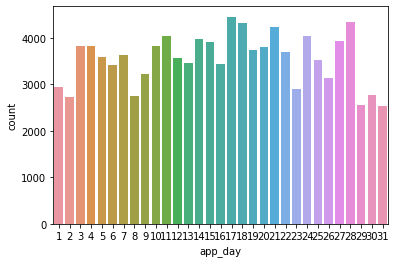

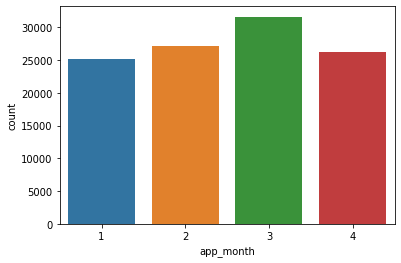

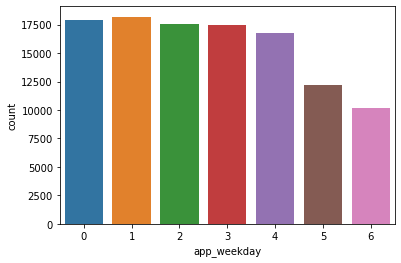

In [18]:
# Посмотрим гистограммы по новым признакам
for col in scr.iloc[:,19:22].columns:
    sns.countplot(x = scr[col], data = scr)
    plt.show()

Видно, что март содержит самое большое количество операций, выходные дни - меньше, чем рабочие.

<AxesSubplot:>

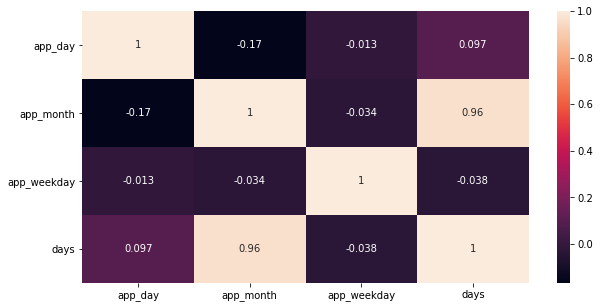

In [19]:
# Оценим новые признаки с помощью матрицы корреляции 
plt.figure(figsize=(10,5))
sns.heatmap(scr.iloc[:,19:].corr(), annot=True)

In [20]:
# Увидели, что признаки app_month и app_day имеют корреляцию, близкую к 1
# Удалим app_month как избыточный
scr.drop(['app_month'], axis = 1, inplace = True)

## Списки колонок, перевод бинарных и категориальных переменных в числа

In [21]:
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные переменные
cat_cols = [
    'education', 
    'region_rating', 
    'home_address', 
    'work_address', 
    'sna', 
    'first_time', 
    'app_weekday'
]

# числовые переменные
num_cols = [
    'age', 
    'decline_app_cnt', 
    'score_bki', 
    'bki_request_cnt', 
    'income', 
    'app_day', 
    'days'
]

Рассмотрим бинарные переменные:

In [22]:
scr[bin_cols]

sex car car_type  good_work foreign_passport
0        M   Y        Y          0                N
1        F   N        N          0                N
2        M   Y        Y          0                Y
3        M   N        N          0                N
4        F   N        N          0                N
...     ..  ..      ...        ...              ...
110143   F   N        N          0                N
110144   M   Y        Y          0                N
110145   M   N        N          0                N
110146   F   N        N          1                N
110147   M   N        N          0                N

[110148 rows x 5 columns]

Переведём бинарные переменные в числа с помощью готового класса LabelEncoder

In [23]:
# Нам рекомендовано посмотреть наивную модель, поэтому сразу преобразуем бинарные переменные в 0 и 1
# Используем LabelEncoder
# Выведем на всякий случай словари значений
label_encoder = LabelEncoder()

for column in bin_cols:
    
    scr[column] = label_encoder.fit_transform(scr[column])
    print(column,dict(enumerate(label_encoder.classes_)))

sex {0: 'F', 1: 'M'}
car {0: 'N', 1: 'Y'}
car_type {0: 'N', 1: 'Y'}
good_work {0: 0, 1: 1}
foreign_passport {0: 'N', 1: 'Y'}


Обработаем категориальные переменные - необходимо перевести категории в числа для признака образование (education)

In [24]:
scr[cat_cols].head()

education  region_rating  home_address  work_address  sna  first_time  \
0       GRD             50             1             2    1           4   
1       SCH             50             1             2    4           3   
2       UGR             50             1             2    1           3   
3       SCH             40             1             2    1           3   
4       GRD             80             2             3    1           3   

   app_weekday  
0            5  
1            4  
2            6  
3            0  
4            1

In [25]:
# Закодируем категории образования
ed_dict = {'SCH': 0, 'UGR': 1, 'GRD': 2, 'PGR': 3, 'ACD': 4}
scr['education'] = scr['education'].replace(ed_dict)

In [26]:
# убедимся в преобразовании категорий   
scr[cat_cols].head()

education  region_rating  home_address  work_address  sna  first_time  \
0          2             50             1             2    1           4   
1          0             50             1             2    4           3   
2          1             50             1             2    1           3   
3          0             40             1             2    1           3   
4          2             80             2             3    1           3   

   app_weekday  
0            5  
1            4  
2            6  
3            0  
4            1

In [27]:
# убедимся во всех преобразованиях
scr[cat_cols+bin_cols].head()

education  region_rating  home_address  work_address  sna  first_time  \
0          2             50             1             2    1           4   
1          0             50             1             2    4           3   
2          1             50             1             2    1           3   
3          0             40             1             2    1           3   
4          2             80             2             3    1           3   

   app_weekday  sex  car  car_type  good_work  foreign_passport  
0            5    1    1         1          0                 0  
1            4    0    0         0          0                 0  
2            6    1    1         1          0                 1  
3            0    1    0         0          0                 0  
4            1    0    0         0          0                 0

## Наивная модель

In [28]:
# Делим датасет на тренировочный и тестовый
scr_train_n = scr.query('sample == 1').drop(['sample'], axis = 1)
scr_test_n = scr.query('sample == 0').drop(['sample'], axis = 1)

X = scr_train_n.drop(['default', 'client_id'], axis = 1).values
Y = scr_train_n['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

In [29]:
model_n = LogisticRegression(max_iter = 1000)
model_n.fit(X_train, y_train)
y_pred = model_n.predict(X_test)

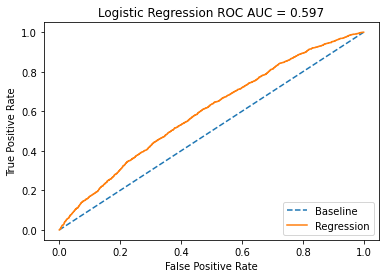

In [30]:
probs = model_n.predict_proba(X_test)
probs = probs[:,1]

roc_auc_curve(y_test, probs)

In [31]:
# Выведем метрики качества
print_metrics(y_test, y_pred)

Accuracy: 0.8762
f1_score: 0.0
Recall: 0.0
MSE: 0.1238


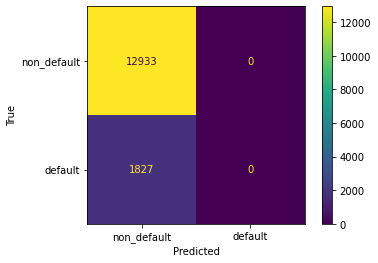

In [32]:
# Визуализируем матрицу ошибок
cm_show(y_test, y_pred)

In [33]:
# Посчитаем матрицу ошибок
# confusion_matrix(y_test, y_pred)

Судя по матрице ошибок, модель вообще не предсказывает дефолтных пользователей, и таким образом, займ будет одобрен всем. Нужно улучшать модель.

## Анализ числовых переменных

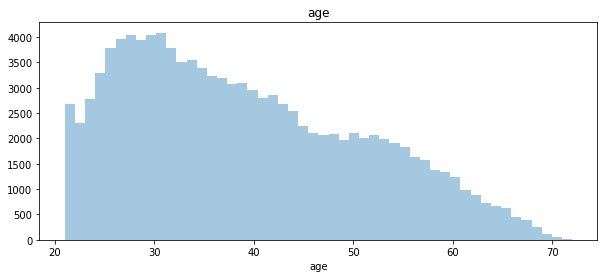

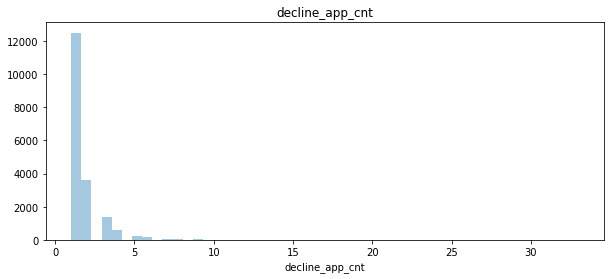

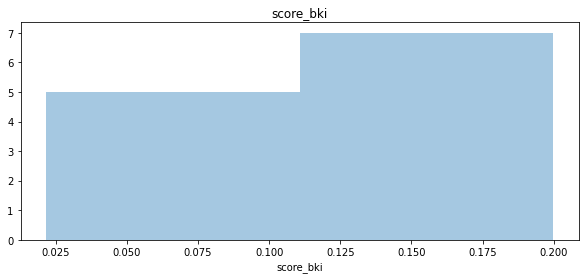

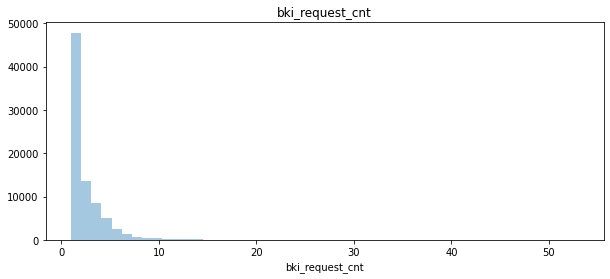

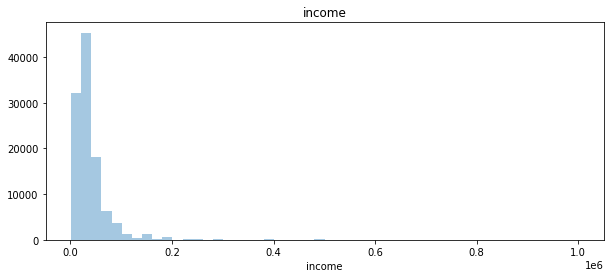

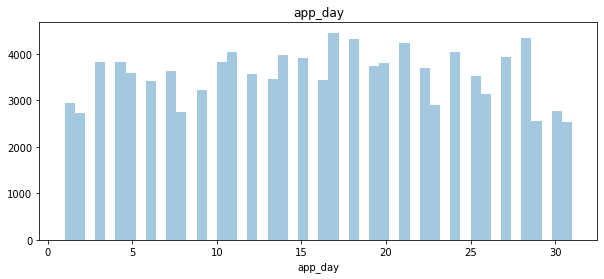

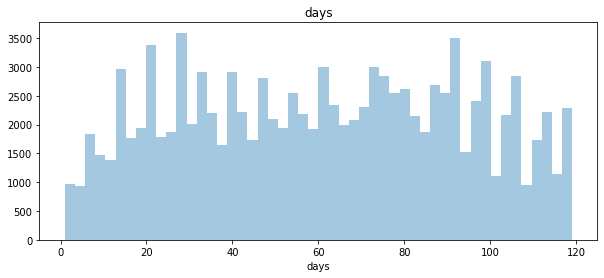

In [34]:
# Построим гистограммы распределения числовых величин
for i in num_cols:
    plt.figure(figsize=(10, 4))
    sns.distplot(scr[i][scr[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

Видим по графикам, что некоторые распределения смещены влево (имеют правый хвост). Это age, bki_request_cnt, decline_app_cnt, income.

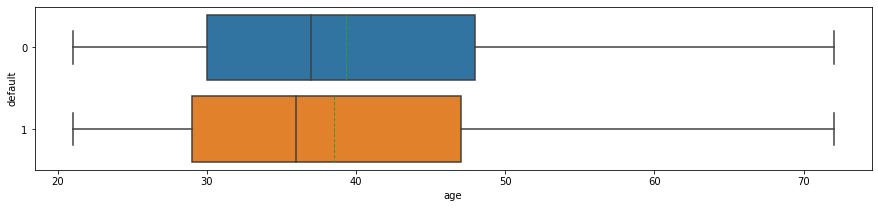

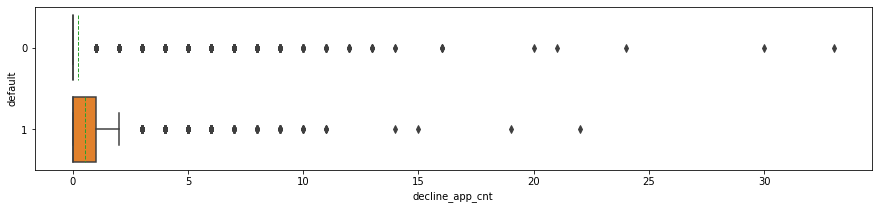

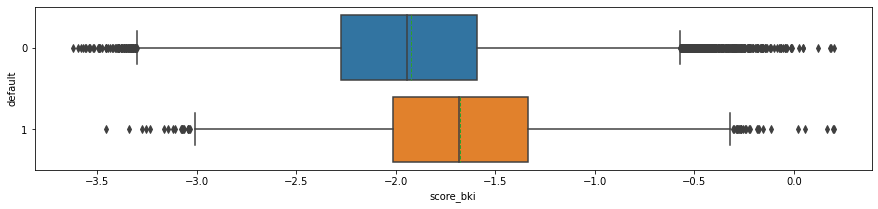

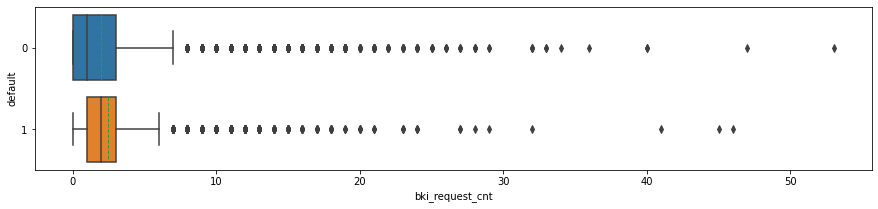

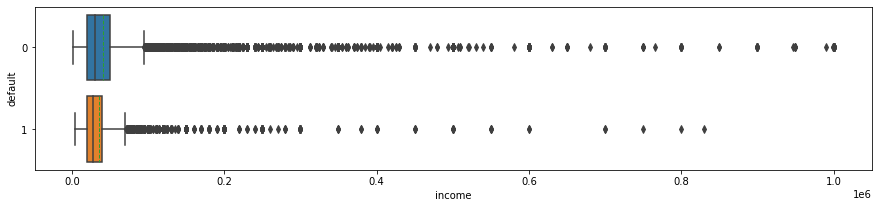

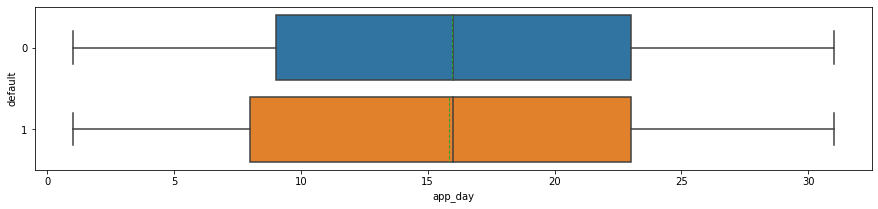

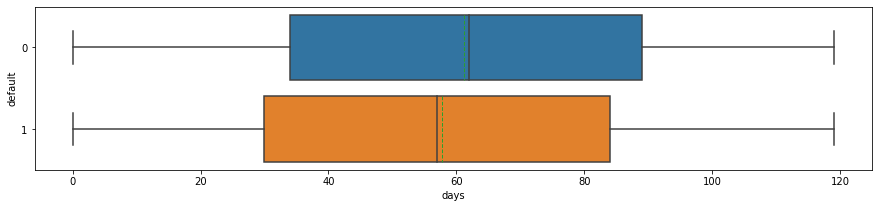

In [35]:
# Посмотрим на боксплоты и выбросы
for col in num_cols:
    plt.figure(figsize=(15,3))
    sns.boxplot(y = scr['default'], x = scr[col],
            showmeans=True, meanline=True, orient = 'h')

Мы видим, что клиенты с дефолтом в среднем более молодые, имели больше запросов в БКИ и больше отказов по заявкам а также чуть более низкий доход. День подачи заявки не влияет на дефолтность, можно его убрать. Нужно поработать с колонками, в которых есть выбросы.

In [36]:
# Удаляем app_day
scr.drop(['app_day'], axis=1, inplace=True)
num_cols.remove('app_day')

Подсчитаем количество выбросов

In [37]:
outliers('decline_app_cnt')
outliers('income')
outliers('bki_request_cnt')
outliers('score_bki')

Для decline_app_cnt IQR: 0.0,  Границы выбросов: [0.0, 0.0].
Всего 18677 выбросов
Для income IQR: 28000.0,  Границы выбросов: [-22000.0, 90000.0].
Всего 7000 выбросов
Для bki_request_cnt IQR: 3.0,  Границы выбросов: [-4.5, 7.5].
Всего 2636 выбросов
Для score_bki IQR: 0.6925455175000004,  Границы выбросов: [-3.299251946250001, -0.5290698762499992].
Всего 518 выбросов


Коллеги подсказывают, что decline_app_cnt и bki_request_cnt можно перевести в категориальные признаки по принципу 1-2-3-много.
Сделаем это.

In [38]:
# Посмотрим наиболее частые значения
scr.decline_app_cnt.value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
15        1
19        1
20        1
21        1
22        1
24        1
30        1
33        1
Name: decline_app_cnt, dtype: int64

In [39]:
# Заменим значения
scr.decline_app_cnt = scr.decline_app_cnt.apply(lambda x: (x if x < 4 else 4))

# Удалим колонку из списка числовых и добавим в список категориальных
num_cols.remove('decline_app_cnt')
cat_cols.append('decline_app_cnt')

Замечание: вообще можно было бы добавить категории для тех которые выше 10 - 10, выше 20 -20, чтобы отразить влияние количества отказов(наверное)

In [40]:
# Посмотрим наиболее частые значения
scr.bki_request_cnt.value_counts()

0     28908
1     27295
2     20481
3     13670
4      8406
5      4960
6      2500
7      1292
8       735
9       459
10      350
11      278
12      217
13      151
14      110
15       81
16       58
17       33
18       32
19       30
21       19
20       14
24       12
23       12
22        8
25        5
27        5
28        5
26        4
32        4
29        3
40        2
33        2
36        1
34        1
41        1
45        1
46        1
47        1
53        1
Name: bki_request_cnt, dtype: int64

In [41]:
# Заменим значения
scr.bki_request_cnt = scr.decline_app_cnt.apply(lambda x: (x if x < 7 else 7))

# Удалим колонку из списка числовых и добавим в список категориальных
num_cols.remove('bki_request_cnt')
cat_cols.append('bki_request_cnt')

<AxesSubplot:>

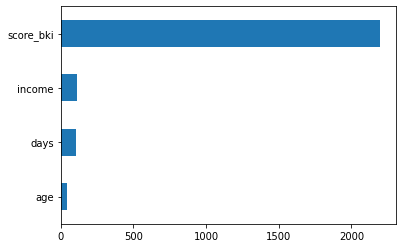

In [42]:
# Проведем оценку значимости признаков с помощью функции f_classif
# Визуализируем результат
imp_num = pd.Series(f_classif(scr[num_cols], scr['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Score_bki самый значимый из числовых

<AxesSubplot:>

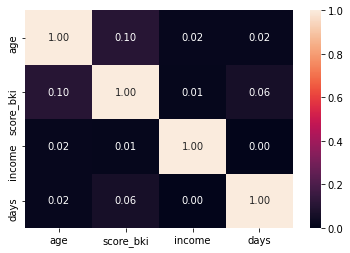

In [43]:
# Оценим корреляцию по Пирсону
sns.heatmap(scr[num_cols].corr().abs(), vmin=0, vmax=1, annot=True, fmt=".2f")

Признаки коррелируют слабо, оставляем для модели все. Вернемся к колонкам со смещенными распределениями и приведем их к более нормальному виду с помощью логарифмирования.

In [44]:
# Логарифмируем числовые колонки age и income
scr['income'] = scr['income'].apply(lambda x: np.log(x + 1))
scr['age'] = scr['age'].apply(lambda x: np.log(x + 1))

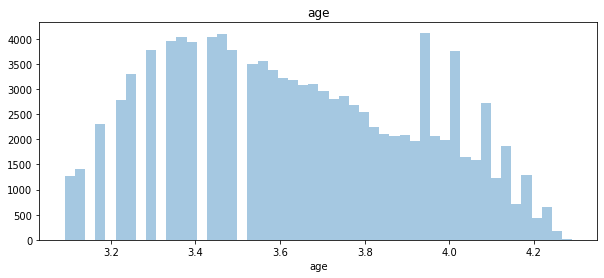

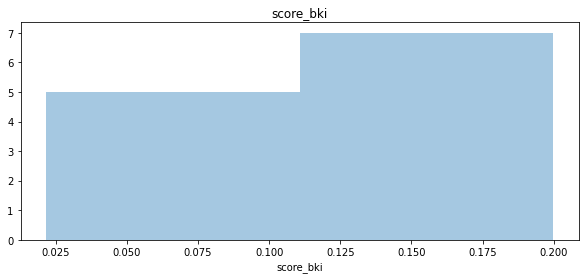

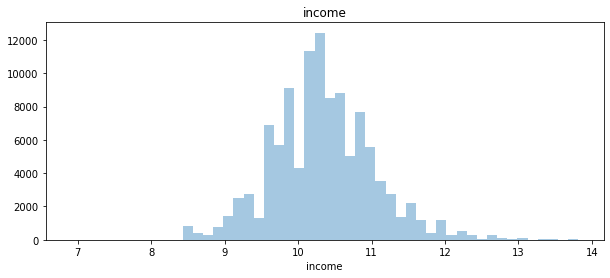

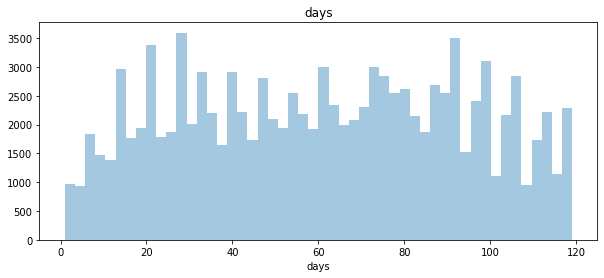

In [45]:
# Построим гистограммы логарифмированных данных
for i in num_cols:
    plt.figure(figsize=(10, 4))
    sns.distplot(scr[i][scr[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

С помощью логарифмирования удалось убрать хвосты у age и income

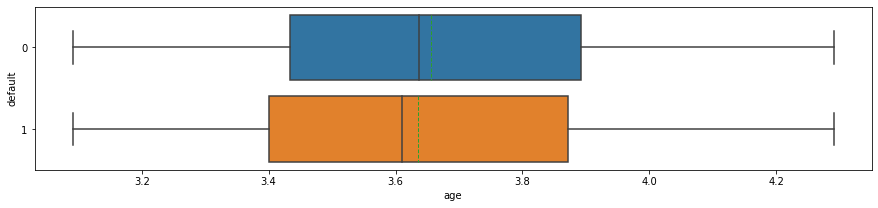

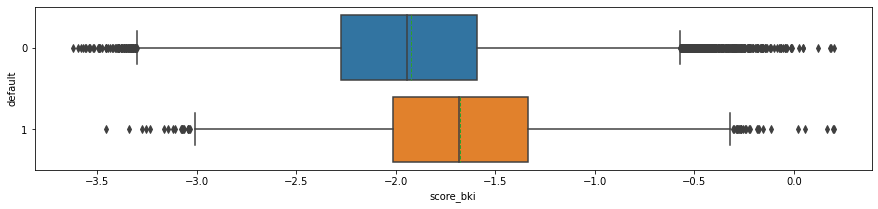

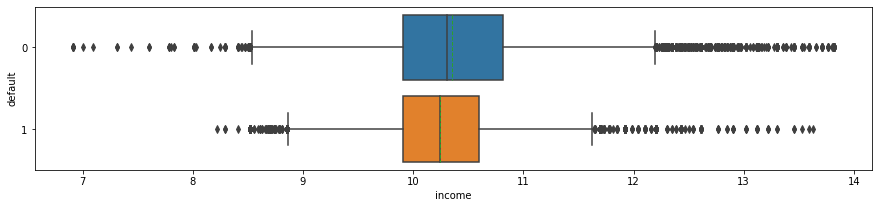

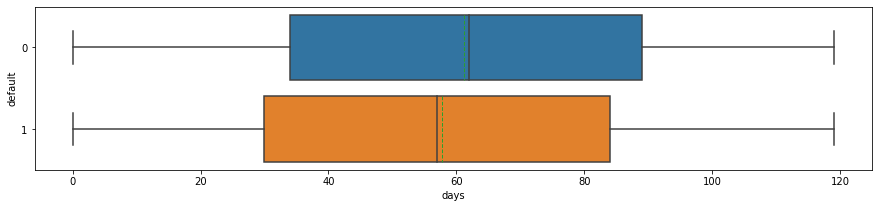

In [46]:
# Посмотрим на боксплоты и выбросы после преобразований
for col in num_cols:
    plt.figure(figsize=(15,3))
    sns.boxplot(y = scr['default'], x = scr[col],
            showmeans=True, meanline=True, orient = 'h')

In [47]:
outliers('income')
outliers('score_bki')


Для income IQR: 0.8754395717201806,  Границы выбросов: [8.590378193705899, 12.092136480586621].
Всего 2609 выбросов
Для score_bki IQR: 0.6925455175000004,  Границы выбросов: [-3.299251946250001, -0.5290698762499992].
Всего 518 выбросов


На данном этапе работы принято решение ничего не делать с выбросами. Распределение дохода вполне правдоподобно, а для решения по выбросам в score_bki нужно углубленное знание темы. Но для проверки модели потом попробуем удалить выбросы.

## Анализ категориальных и бинарных признаков

Оценим значимость категориальных и бинарных переменных с помощью функции mutual_info_classif

<AxesSubplot:>

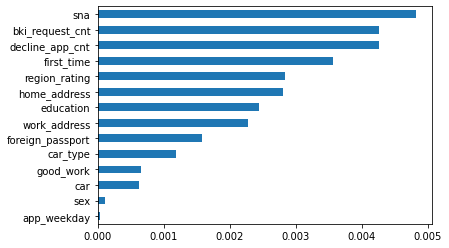

In [48]:
imp_cat = Series(mutual_info_classif(scr[bin_cols + cat_cols], scr['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Судя по гистограмме, самый важный признак - это связь заемщика с другими клиентами банка. Количество запросов в БКИ и количество отказов имеют примерно одинковую важность. Оставим все показатели.

<AxesSubplot:>

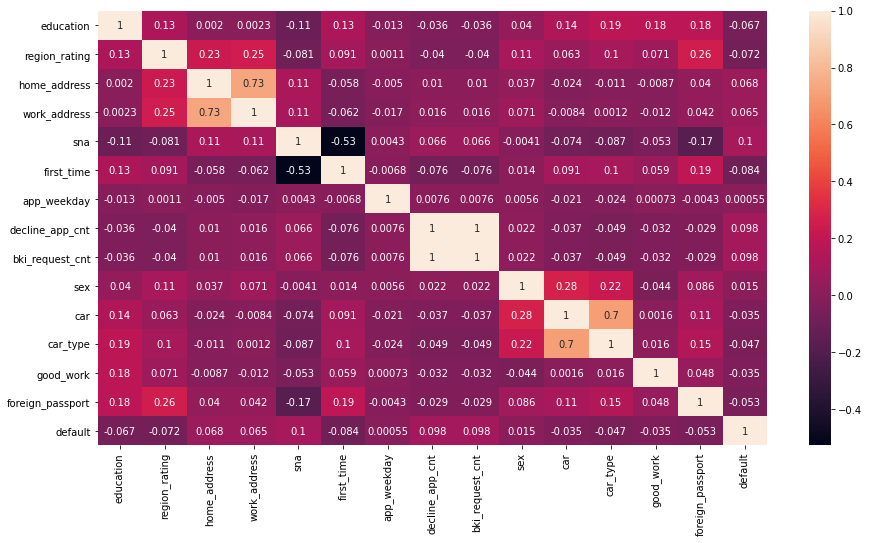

In [49]:
# Построим матрицу корреляций для категориальных признаков:
plt.figure(figsize=(15,8))
sns.heatmap(scr[cat_cols + bin_cols + ['default']].corr(), annot=True)

Видим, что рабочий и домашний адрес имеют довольно высокую корреляцию, так же как и наличие и тип машины. Как ужебыло написано ранее(после профайлинга), попробуем создать новые признаки вместо существующих.

## Feature engineering

Для work_adress и home_adress создаём переменную address их перемножением.

In [50]:
scr['address'] = scr.work_address*scr.home_address
scr.head()

client_id  education  sex       age  car  car_type  decline_app_cnt  \
0      74835          2    1  3.401197    1         1                0   
1      17527          0    0  3.688879    0         0                4   
2      75683          1    1  3.931826    1         1                0   
3      26883          0    1  4.043051    0         0                0   
4      28862          2    0  3.663562    0         0                0   

   good_work  score_bki  bki_request_cnt  ...  work_address     income  sna  \
0          0  -2.271884                0  ...             2  10.819798    1   
1          0  -1.504999                4  ...             2   8.517393    4   
2          0  -1.691339                0  ...             2  10.308986    1   
3          0  -2.374182                0  ...             2   9.741027    1   
4          0  -2.487502                0  ...             3  11.695255    1   

   first_time  foreign_passport  sample  default  app_weekday  days  address  
0           4                 0       0        0            5    80        2  
1           3                 0       0        0            4    23        2  
2           3                 1       0        0            6    81        2  
3           3                 0       0        0            0    33        2  
4           3                 0       0        0            1    34        6  

[5 rows x 22 columns]

Для car и car_type создадим единый признак: 0 - нет авто, 1 - национальное, 2 - иномарка

In [51]:
scr['cars'] = scr.apply(lambda x: 2 if x.car==1 and x.car_type==1 else (1 if x.car==1 and x.car_type==0 else 0), axis=1)

Внесём новые признаки в список категориальных.

In [52]:
cat_cols.append('address')
cat_cols.append('cars')

Оценим значимость новых признаков

<AxesSubplot:>

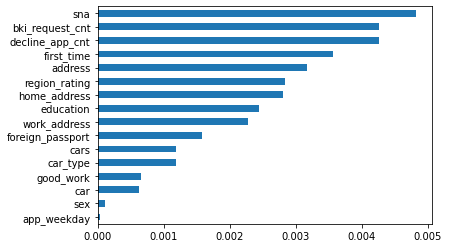

In [53]:
imp_cat = Series(mutual_info_classif(scr[bin_cols + cat_cols], scr['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [54]:
# сохраним промежуточный вариант перед удалением старых признаков
scr1 = scr.copy()

In [55]:
scr = scr1.copy()

In [56]:
scr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  int64  
 2   sex               110148 non-null  int64  
 3   age               110148 non-null  float64
 4   car               110148 non-null  int64  
 5   car_type          110148 non-null  int64  
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  float64
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

Признак cars такой же по значимости, как car_type и значительней чем car. Признак address более значимый чем home_address и work_address. Удалим старые признаки из списков и датафрейма.

In [57]:
# удаление из списков
cat_cols.remove('home_address')
cat_cols.remove('work_address')
bin_cols.remove('car')
bin_cols.remove('car_type')

# удаление  из датафрейма
scr.drop(['home_address', 'work_address', 'car', 'car_type'], axis=1, inplace=True)

In [58]:
# Проверим, какие категориальные признаки имеем
scr[cat_cols].head()

education  region_rating  sna  first_time  app_weekday  decline_app_cnt  \
0          2             50    1           4            5                0   
1          0             50    4           3            4                4   
2          1             50    1           3            6                0   
3          0             40    1           3            0                0   
4          2             80    1           3            1                0   

   bki_request_cnt  address  cars  
0                0        2     2  
1                4        2     0  
2                0        2     2  
3                0        2     0  
4                0        6     0

In [59]:
#Применим One-Hot encoding для категориальных переменных
scr = pd.get_dummies(scr, columns = cat_cols)

scr.head()

client_id  sex       age  good_work  score_bki     income  \
0      74835    1  3.401197          0  -2.271884  10.819798   
1      17527    0  3.688879          0  -1.504999   8.517393   
2      75683    1  3.931826          0  -1.691339  10.308986   
3      26883    1  4.043051          0  -2.374182   9.741027   
4      28862    0  3.663562          0  -2.487502  11.695255   

   foreign_passport  sample  default  days  ...  bki_request_cnt_4  address_1  \
0                 0       0        0    80  ...                  0          0   
1                 0       0        0    23  ...                  1          0   
2                 1       0        0    81  ...                  0          0   
3                 0       0        0    33  ...                  0          0   
4                 0       0        0    34  ...                  0          0   

   address_2  address_3  address_4  address_6  address_9  cars_0  cars_1  \
0          1          0          0          0          0       0       0   
1          1          0          0          0          0       1       0   
2          1          0          0          0          0       0       0   
3          1          0          0          0          0       1       0   
4          0          0          0          1          0       1       0   

   cars_2  
0       1  
1       0  
2       1  
3       0  
4       0  

[5 rows x 56 columns]

In [60]:
# добавим новые полиномиальные признаки
pf = PolynomialFeatures(2, include_bias = False)
poly_data = pf.fit_transform(scr[num_cols])[:, len(num_cols):]
poly_cols = pf.get_feature_names()[len(num_cols):]
poly_df = pd.DataFrame(poly_data, columns=poly_cols)
#scr = scr.join(poly_df,  how='left')

Пока что не будем добавлять полиномиальные признаки, но потом вернёмся и проверим.

In [61]:
poly_df

x0^2     x0 x1      x0 x2       x0 x3      x1^2      x1 x2  \
0       11.568144 -7.727125  36.800270  272.095791  5.161455 -24.581323   
1       13.607832 -5.551760  31.419637   84.844227  2.265022 -12.818669   
2       15.459253 -6.650050  40.533135  318.477876  2.860628 -17.435990   
3       16.346264 -9.598941  39.383473  133.420692  5.636742 -23.126977   
4       13.421684 -9.113118  42.846289  124.561096  6.187668 -29.091976   
...           ...       ...        ...         ...       ...        ...   
110143  14.658495 -6.861172  37.294901  237.375767  3.211495 -17.456548   
110144  13.970174 -7.692233  41.698432  306.488909  4.235484 -22.959919   
110145  12.011325 -5.242392  37.133419  384.696685  2.288064 -16.207034   
110146  11.568144 -5.031506  32.218800   10.203592  2.188428 -14.013406   
110147  12.640500 -6.274163  36.003840   78.217657  3.114206 -17.870650   

             x1 x3        x2^2        x2 x3     x3^2  
0      -181.750694  117.068035   865.583863   6400.0  
1       -34.614980   72.545986   195.900043    529.0  
2      -136.998462  106.275192   835.027865   6561.0  
3       -78.348022   94.887616   321.453906   1089.0  
4       -84.575082  136.778998   397.638682   1156.0  
...            ...         ...          ...      ...  
110143 -111.107990   94.887616   603.943702   3844.0  
110144 -168.758398  124.462244   914.813714   6724.0  
110145 -167.902451  114.799224  1189.302839  12321.0  
110146   -4.438001   89.733590    28.418345      9.0  
110147  -38.823647  102.549468   222.786764    484.0  

[110148 rows x 10 columns]

In [62]:
scr.head()

client_id  sex       age  good_work  score_bki     income  \
0      74835    1  3.401197          0  -2.271884  10.819798   
1      17527    0  3.688879          0  -1.504999   8.517393   
2      75683    1  3.931826          0  -1.691339  10.308986   
3      26883    1  4.043051          0  -2.374182   9.741027   
4      28862    0  3.663562          0  -2.487502  11.695255   

   foreign_passport  sample  default  days  ...  bki_request_cnt_4  address_1  \
0                 0       0        0    80  ...                  0          0   
1                 0       0        0    23  ...                  1          0   
2                 1       0        0    81  ...                  0          0   
3                 0       0        0    33  ...                  0          0   
4                 0       0        0    34  ...                  0          0   

   address_2  address_3  address_4  address_6  address_9  cars_0  cars_1  \
0          1          0          0          0          0       0       0   
1          1          0          0          0          0       1       0   
2          1          0          0          0          0       0       0   
3          1          0          0          0          0       1       0   
4          0          0          0          1          0       1       0   

   cars_2  
0       1  
1       0  
2       1  
3       0  
4       0  

[5 rows x 56 columns]

In [63]:
scr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 56 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   client_id          110148 non-null  int64  
 1   sex                110148 non-null  int64  
 2   age                110148 non-null  float64
 3   good_work          110148 non-null  int64  
 4   score_bki          110148 non-null  float64
 5   income             110148 non-null  float64
 6   foreign_passport   110148 non-null  int64  
 7   sample             110148 non-null  int64  
 8   default            110148 non-null  int64  
 9   days               110148 non-null  int64  
 10  education_0        110148 non-null  uint8  
 11  education_1        110148 non-null  uint8  
 12  education_2        110148 non-null  uint8  
 13  education_3        110148 non-null  uint8  
 14  education_4        110148 non-null  uint8  
 15  region_rating_20   110148 non-null  uint8  
 16  re

In [64]:
np.sum(scr.score_bki.isna())

0

In [65]:
scr.score_bki

0        -2.271884
1        -1.504999
2        -1.691339
3        -2.374182
4        -2.487502
            ...   
110143   -1.792064
110144   -2.058029
110145   -1.512635
110146   -1.479334
110147   -1.764711
Name: score_bki, Length: 110148, dtype: float64

## Пробуем обучать. Модель 1

In [66]:
# Делим датасет на тренировочный и тестовый
scr_train = scr.query('sample == 1').drop(['sample'], axis = 1)
scr_test = scr.query('sample == 0').drop(['sample'], axis = 1)

In [67]:
# Проверим размерность тренировочной и тестовой выборок
print('Тренировочный датасет: ', scr_train.shape,'\nТестовый датасет: ', scr_test.shape)

Тренировочный датасет:  (73799, 55) 
Тестовый датасет:  (36349, 55)


Количество строк не изменилось.

In [68]:
# Стандартизация числовых переменных
num_cols_std = StandardScaler().fit_transform(scr_train[num_cols].values)

In [69]:
# Заменим числовые данные на нормализованные
# Выделим целевую переменную
X = np.hstack([scr_train.drop(num_cols + ['default'], axis=1).values, num_cols_std])
# X = scr_train.drop(['default'], axis = 1).values
Y = scr_train['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

In [70]:
X_train

array([[ 8.67240000e+04,  1.00000000e+00,  0.00000000e+00, ...,
         2.35156225e+00,  2.25386115e+00,  9.63977564e-01],
       [ 2.77690000e+04,  1.00000000e+00,  0.00000000e+00, ...,
        -5.68926825e-01,  8.15857386e-01, -8.72788901e-01],
       [ 1.28440000e+04,  1.00000000e+00,  0.00000000e+00, ...,
         7.22675517e-01,  8.15857386e-01, -1.30863179e+00],
       ...,
       [ 1.62260000e+04,  1.00000000e+00,  0.00000000e+00, ...,
        -5.91119469e-01,  5.28244398e-01, -1.21523689e+00],
       [ 3.69500000e+03,  1.00000000e+00,  0.00000000e+00, ...,
        -7.92932885e-01, -5.28877062e-02, -1.65107978e+00],
       [ 9.43610000e+04,  0.00000000e+00,  0.00000000e+00, ...,
         1.17524650e+00, -9.53822773e-01,  1.18189901e+00]])

In [71]:
y_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [72]:
model_1 = LogisticRegression(solver = 'liblinear', max_iter = 1000)
# model_1.fit(X_train, y_train)
# y_pred = model_1.predict(X_test)

In [73]:
model_1.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

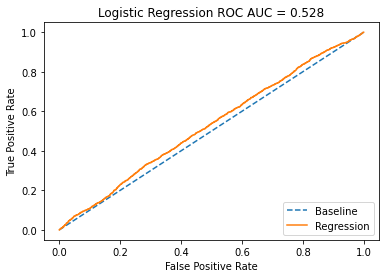

In [74]:
probs = model_1.predict_proba(X_test)
probs = probs[:,1]

roc_auc_curve(y_test, probs)

Добавление признаков cars и address улучшило модель на 0.01

In [75]:
print_metrics(y_test, y_pred)

Accuracy: 0.8762
f1_score: 0.0
Recall: 0.0
MSE: 0.1238


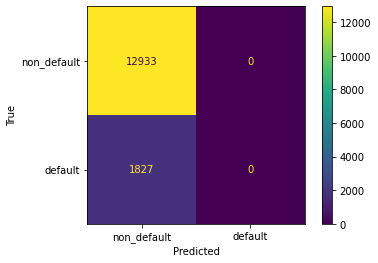

In [76]:
cm_show(y_test, y_pred)

Точность предсказаний практически не изменилась, модель хоть и находит дефолтных заемщиков, но делает это очень плохо.

## Модель 2. Oversampling

<AxesSubplot:ylabel='Frequency'>

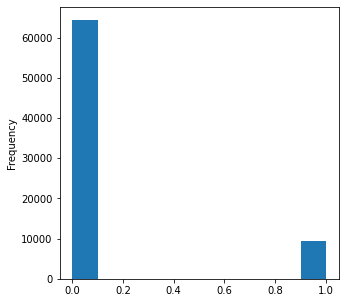

In [77]:
# Посмотрим на распределение целевого признака 'default':
scr_train['default'].plot(kind = 'hist',figsize=(5,5)) 

In [78]:
# Применим к выборкам оверсемплинг
oversample = SMOTE()
X_sm, y_sm = oversample.fit_resample(X, Y)

In [79]:
(X_sm.shape, y_sm.shape)

((128854, 54), (128854,))

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = 0.20, random_state = 42)

In [81]:
model_2 = LogisticRegression(solver = 'liblinear', max_iter = 2000)
model_2.fit(X_train, y_train)
y_pred = model_2.predict(X_test)

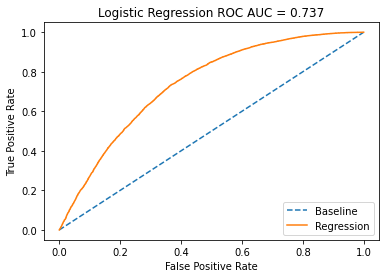

In [82]:
probs = model_2.predict_proba(X_test)
probs = probs[:,1]

roc_auc_curve(y_test, probs)

In [83]:
# Выведем метрики
print_metrics(y_test, y_pred)

Accuracy: 0.6762
f1_score: 0.6767
Recall: 0.6773
MSE: 0.3238


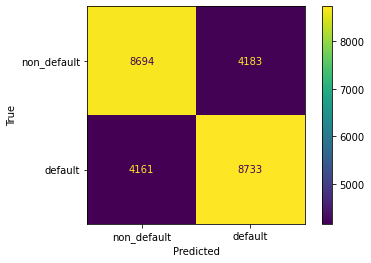

In [84]:
# Матрица ошибок
cm_show(y_test, y_pred)

## Модель 3. Undersampling

In [85]:
# Применим к выборкам undersampling
us = RandomUnderSampler(random_state=42)
X_us, y_us = us.fit_resample(X, Y)

In [86]:
(X_us.shape, y_us.shape)

((18744, 54), (18744,))

In [87]:
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_us, y_us, test_size = 0.20, random_state = 42)

In [88]:
model_3 = LogisticRegression(solver = 'liblinear', max_iter = 2000)
model_3.fit(X_train_us, y_train_us)
y_pred_us = model_3.predict(X_test_us)

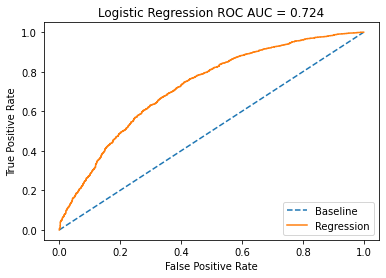

In [89]:
probs_us = model_3.predict_proba(X_test_us)
probs_us = probs_us[:,1]

roc_auc_curve(y_test_us, probs_us)

In [90]:
print_metrics(y_test_us, y_pred_us)

Accuracy: 0.6663
f1_score: 0.6656
Recall: 0.6686
MSE: 0.3337


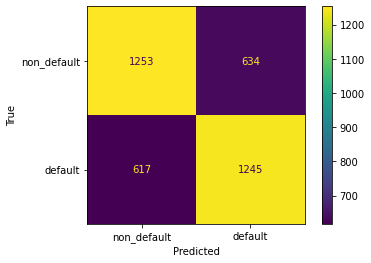

In [91]:
cm_show(y_test_us, y_pred_us)

Видим, что результат от оверсемплинга чуть лучше, оставим его. В обоих случаях модель довольно равномерно предсказывает дефолтных и недефолтных заемщиков. 

Осталось попробовать гиперпараметры.

## Модель 4. Гиперпараметры

In [92]:
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

n_iter = 20

# Создадим гиперпараметры
# l1, l2 - параметры регуляризации
hyperparameters  = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'],
     'max_iter': [n_iter]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'],
     'max_iter': [n_iter]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'],
     'max_iter': [n_iter]}
 ]
# Добавим типы регуляризации
# penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
# C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
# hyperparameters = dict(C=C, penalty=penalty)

model_4 = LogisticRegression(random_state = 42)
model_4.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [93]:
model_5 = LogisticRegression(penalty = 'l1', class_weight = 'balanced', max_iter = 1000, solver = 'liblinear', C = 1)
model_5.fit(X_train, y_train)
y_pred = model_5.predict(X_test)

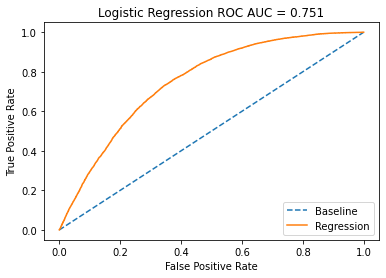

In [94]:
probs = model_5.predict_proba(X_test)
probs = probs[:,1]

roc_auc_curve(y_test, probs)

In [95]:
print_metrics(y_test, y_pred)

Accuracy: 0.6896
f1_score: 0.6942
Recall: 0.704
MSE: 0.3104


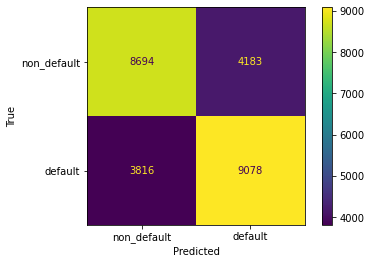

In [96]:
cm_show(y_test, y_pred)

Матрица ошибок стала чуть лучше. Остальные метрики слегка упали, но целевая метрика на данном шаге максимальная, поэтому тут остановимся.

## Submission

In [97]:
# Стандартизируем тестовые данные
num_cols_test_std = StandardScaler().fit_transform(scr_test[num_cols].values)
X_test = np.hstack([scr_test.drop(num_cols + ['default'], axis=1), num_cols_test_std])
y_probs = model_2.predict_proba(X_test)[:,1]


In [98]:
y_probs

array([0.16602894, 0.76907955, 0.32233494, ..., 0.7846678 , 0.7434872 ,
       0.67672288])

In [99]:
submission = pd.DataFrame(scr_test.client_id)
submission['default'] = y_probs

In [100]:
submission.to_csv('submission.csv', index = False)

In [101]:
submission.sample(10)

client_id   default
27263      28228  0.498819
3852       47957  0.649570
8278       23459  0.434716
13600      84814  0.150184
6607       71277  0.247075
6560       33169  0.174398
7158       54393  0.476889
12276      17426  0.547136
17740      58144  0.470672
10770     105810  0.581055